# Dataset with $|m_\tau - 1968|<50$

In [20]:
import zfit
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hep_ml import splot

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
import functions as fct
from fit import launch_fit, save_params, plot_hist_fit, plot_hist_fit_particle

## Retrieve data

In [21]:
df = fct.load_data(years, magnets, type_data='data_strip', vars=['B0_M','tau_M'],
                            cut_DeltaM=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/data_strip/all_data_strip.root


In [22]:
name_data = 'all_data_strip_cutDeltaM_Ds_V8'

In [23]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M
df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

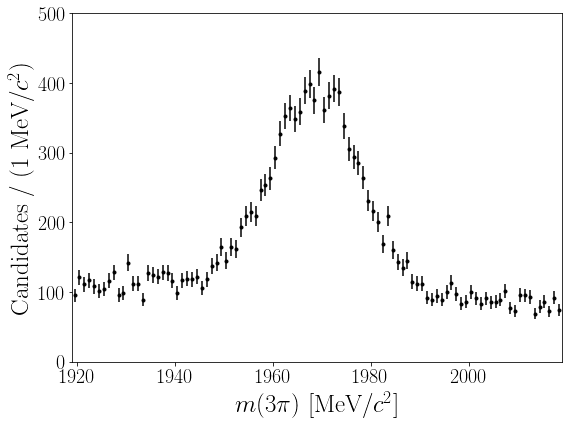

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/tau_M_all_data_strip_cutDeltaM_Ds_V8.pdf


In [5]:
fct.plot_hist_particle({name_data:df_Ds},'tau_M',
              n_bins = 100, mode_hist = False, colors='black')

## Fit on $m(3\pi)$ = gaussian (signal) + exponential (background)

### Initial conditions

In [ ]:
n_events_tau_M = len(df_Ds)
initial_values_tau = { # it seems that this one works with almost every BDT cut....
    'mu_tau': {
        'value' : 1969.,
        'low': 1965.,
        'high': 1975.,     
    },
    'sigma_tau': {
        'value' : 9.4,
        'low': 5.,
        'high': 15.,
    },
    'n_bkg_tau': {
        'value' : n_events_tau_M*2/3,
        'low': 0,
        'high': n_events_tau_M,  
    },
    'n_sig_tau': {
        'value' : n_events_tau_M/3,
        'low': 0,
        'high': n_events_tau_M,  
    },
    'lambda_tau': {
        'value' : -0.003,
        'low': -0.01,
        'high': -0.0001  
    }
}

### Parameters and pdf

In [12]:
obs_tau = zfit.Space("x", limits=(low_tau_M, high_tau_M))
zparams_tau = {}

for var_tau in initial_values_tau.keys():
    zparams_tau[var_tau] = zfit.Parameter(var_tau, initial_values_tau[var_tau]['value'], 
                                     initial_values_tau[var_tau]['low'], initial_values_tau[var_tau]['high'])

In [13]:
name_params_tau = {
    f'mu_tau':'$\mu_{m_{D_s}}$',
    f'sigma_tau':'$\sigma_{m_{D_s}}$',
    f'n_bkg_tau':'$n_{bkg,c}$',
    f'n_sig_tau':'$n_{sig,D_s}$',
    f'lambda_tau':'$\\lambda$',
}

In [14]:
gaussian_tau = zfit.pdf.Gauss(zparams_tau["mu_tau"],zparams_tau["sigma_tau"],obs=obs_tau)
exponential_tau = zfit.pdf.Exponential(zparams_tau["lambda_tau"], obs=obs_tau)

gaussian_ext_tau = gaussian_tau.create_extended(zparams_tau["n_sig_tau"])
exp_ext_tau = exponential_tau.create_extended(zparams_tau["n_bkg_tau"])
model_tau = zfit.pdf.SumPDF([gaussian_ext_tau, exp_ext_tau]) # gauss is folded by frac

data_tau = zfit.Data.from_pandas(df_Ds['tau_M'],obs=obs_tau)

### Launch fit

In [15]:
result_tau, params_tau = launch_fit(model_tau, data_tau, extended=True)

------------------------------------------------------------------
| FCN = -7.151e+04              |     Ncalls=126 (126 total)     |
| EDM = 4.61e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name            value    minuit_hesse         minuit_minos    at limit
----------  ---------  --------------  -------------------  ----------
n_sig_tau        6816     +/- 1.3e+02  -1.3e+02   +1.3

    ------------------------------------------------------------------
    | FCN = -7.151e+04              |     Ncalls=126 (126 total)     |
    | EDM = 4.61e-05 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name            value    minuit_hesse         minuit_minos    at limit
    ----------  ---------  --------------  -------------------  ----------
    n_sig_tau        6816     +/- 1.3e+02  -1.3e+02   +1.3e+02       False
    n_bkg_tau        9932     +/- 1.4e+02  -1.4e+02   +1.4e+02       False
    mu_tau           1969     +/-    0.17  -   0.17   +   0.18       False
    sigma_tau       9.267     +/-    0.18  -   0.17   +   0.18       False
    lambda_tau  -0.003488     +/- 0.00037  -0.00037   +0.00037       False


/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:444: UserWarning: The function <function Space.limits at 0x7f256fda95f0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[1919.]]), array([[2019.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:35: UserWarning: The function <function Space.area at 0x7f256fdb09e0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[1919.]]), array([[2019.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  return counts.sum() * obs.area() / n_bins
findfont: Font family ['serif'] not found. Falling back to Dej

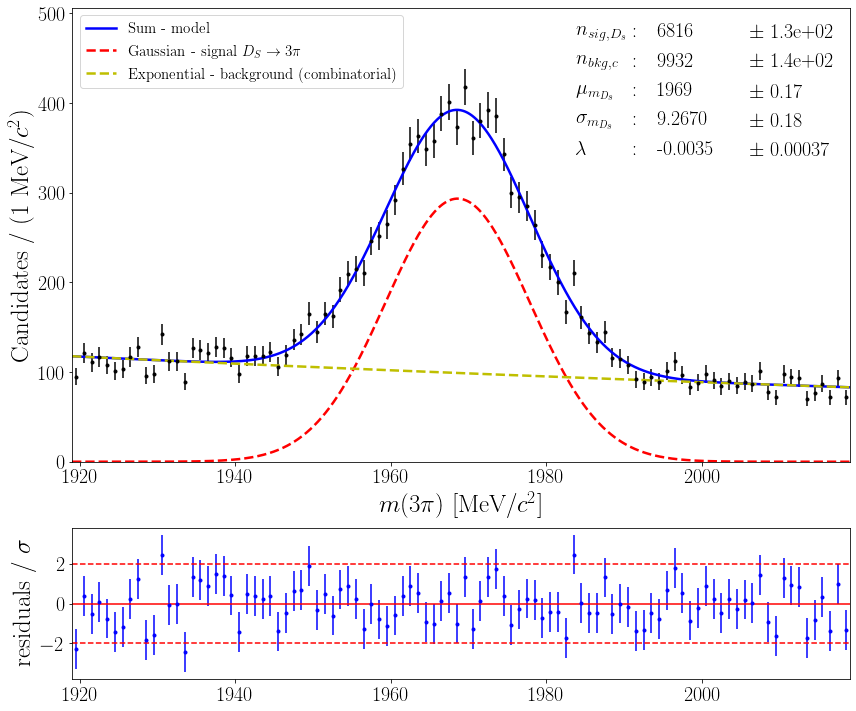

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_Ds_V8/tau_M_all_data_strip_cutDeltaM_Ds_V8_fit.pdf


In [16]:
plot_hist_fit_particle(df,'tau_M',models = [model_tau,gaussian_ext_tau,exp_ext_tau], 
                       name_models = [None, '$D_S \\to 3\pi$','(combinatorial)'], colors = ['b','r','y'],
                       obs=obs_tau, n_bins = 100,mode_hist = False, name_data=name_data, 
                      params=params_tau,name_params=name_params_tau, fontsize_leg=15.)

In [17]:
save_params(params_tau,name_data,True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_Ds_V8_params.json


## Calculate sWeights

We get
- $f_g(m)$, the signal Ds PDF
- $f_e(m)$, the background Ds PDF
Besides, our dataset is given by a list of events, each event is characterised by $m_{3\pi})$

We define the probability of the event $e$ being a $D_s$ by:
$$P\left(e = D_s\right)=\frac{f_g(m_{e, 3\pi})}{\sum_{event\ k}{\left(f_g(m_{k,3\pi})+f_e(m_{k, 3\pi})\right)}}$$

In [24]:
# Probability that the candidate is actually a Ds particle.
mass = df_Ds['tau_M']
probs = pd.DataFrame(dict(sig=gaussian_ext_tau.pdf(mass), bkg=exp_ext_tau.pdf(mass)))
probs = probs.div(probs.sum(axis=1), axis=0) # normalisation.......3

NameError: name 'gaussian_ext_tau' is not defined

In [ ]:
weights = splot.compute_sweights(probs)

In [ ]:
fct.dump_pickle(weights, name_data)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


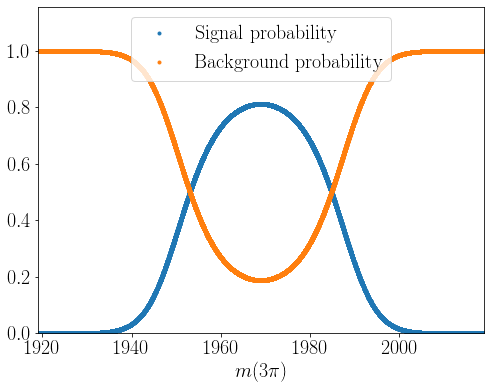

In [15]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mass, probs.sig,'.', label='Signal probability')
ax.plot(mass, probs.bkg,'.', label='Background probability')

plt.xlim(low_tau_M, high_tau_M) 
plt.xlabel('$m(3\pi)$',fontsize=20)

fct.fix_plot(ax)


plt.show()
plt.close()

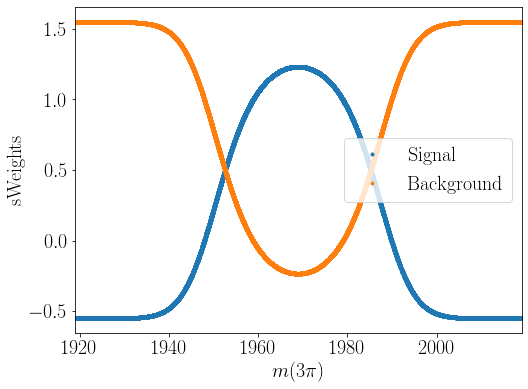

In [26]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mass, weights.sig,'.', label='Signal')
ax.plot(mass, weights.bkg,'.', label='Background')

plt.xlim(low_tau_M, high_tau_M) 
fct.fix_plot(ax, ymax=None)

plt.xlabel('$m(3\pi)$',fontsize=20)
plt.ylabel('sWeights',fontsize=20)

plt.show()
plt.close()

## Apply the sWeights on $m(B^0)$
We are going to fit the $m\left(B^0 \to D^* D_s\right)$ component by selecting it using the sWeights

In [5]:
name_data = 'all_data_strip_cutDeltaM_Ds_V8'
low = 5150.
high = 5550.

In [6]:
weights =  fct.retrieve_pickle(name_data)

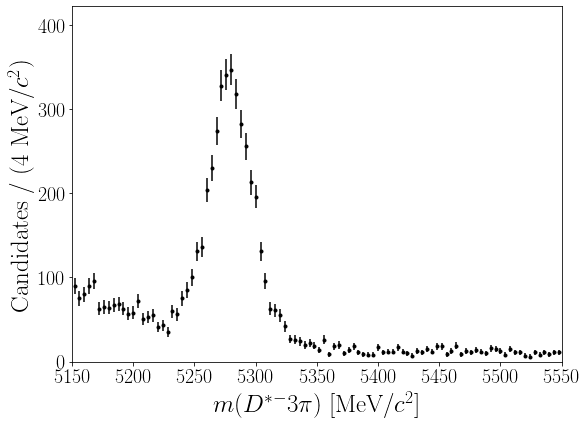

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_Ds_V8.pdf


In [7]:
fct.plot_hist_particle({name_data:df_Ds},'B0_M',
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black')

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:580: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


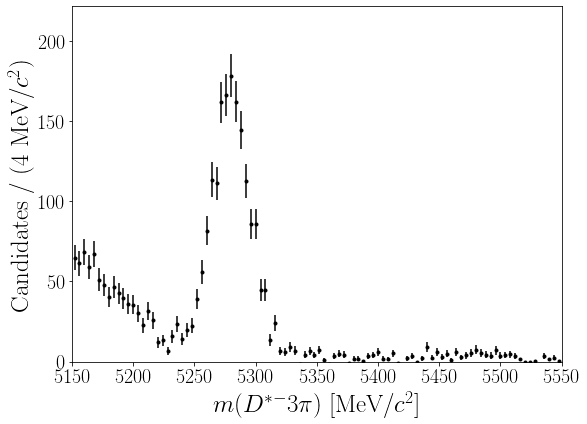

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8.pdf


In [26]:
name_data = 'all_data_strip_cutDeltaM_Ds_weighted_V8'
fct.plot_hist_particle({name_data:df_Ds},'B0_M',
              low = low, high = high,
              n_bins = 100, mode_hist = False, colors='black', weights=weights.sig)

## Fit with the sWeights
- Signal ($B^0 \to D^* D_s$): Double CB pdf
- Combinatorial background (fake $D^*$ candidates): exponential pdf
- Partially reconstructed decays : gaussian pdf

In [7]:
name_data = 'all_data_strip_cutDeltaM_Ds_weighted_V8'

In [8]:
with open(f'{loc.JSON}/data_strip_p/all_data_strip_params.json', 'r') as f:
    mu2_p = json.load(f)['mu2']

In [9]:
n_events_B0Ds = len(df_Ds.query(f'B0_M > {low} and B0_M < {high}'))

n_sig_k = 1600
n_bkg_k = 300
n_bkg2_k = 800

# n_sig_B0Ds         1594     +/-      50  -     48   +     52       False
# n_bkg_B0Ds        285.2     +/-      56  -     25   +     51       False
# n_bkg2_B0Ds       832.7     +/-      58  -     65   +     40       False
# alphaL_B0Ds       3.499     +/-    0.22  -    1.1   +    1.5       False
# nL_B0Ds           1.737     +/-    0.45  -   0.29   +   0.42       False
# mu_B0Ds            5280     +/-    0.26  -   0.53   +   0.48       False
# alphaR_B0Ds   1.007e-05     +/- 5.4e-05  -   0.72   +      5       False
# nR_B0Ds            69.8     +/-     2.6  -     65   +     65       False
# sigma_B0Ds        15.14     +/-    0.44  -   0.56   +   0.46       False
# lambda_B0Ds  -5.222e-05     +/-  0.0015  -0.00095   +0.00056       False
# sigma2_B0Ds       77.21     +/-     4.1  -    3.3   +    3.2       False

initial_values_B0Ds = {
    # Signal
    'mu_B0Ds'       :{ 'value': 5279.                         , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
    'sigma_B0Ds'    :{ 'value': 17.9                          , 'low': 17.-10.        , 'high': 17.+10.              , 'floating': True},
#     'alphaL_B0Ds'   :{ 'value': 3.4                           , 'low': 0.1            , 'high': None                 , 'floating': True},
#     'alphaR_B0Ds'   :{ 'value': 0.1                           , 'low': 0.             , 'high': 5.                   , 'floating': True},
#     'nL_B0Ds'       :{ 'value': 1.8                           , 'low': None           , 'high': 10.                  , 'floating': True},
#     'nR_B0Ds'       :{ 'value': 20.                           , 'low': 0.1            , 'high': 70.                  , 'floating': True},
    'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Combinatorial background
    'lambda_B0Ds'   :{ 'value': -0.0001                       , 'low': -0.001        , 'high': -0.000001            , 'floating': True},
    'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
    # Partially reconstructed particles
    'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
    'sigma2_B0Ds'   :{ 'value': 80.                           , 'low': 20.            , 'high': 5150.-mu2_p          , 'floating': True},
    'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
}


In [10]:
obs_B0Ds = zfit.Space("x", limits=(low, high))

zparams_B0Ds = {}
for var in initial_values_B0Ds.keys():
    try:
        zparams_B0Ds[var] = zfit.Parameter(var,
                                      initial_values_B0Ds[var]['value'], 
                                      initial_values_B0Ds[var]['low'], 
                                      initial_values_B0Ds[var]['high'],
                                      floating = initial_values_B0Ds[var]['floating'])
    except:
        pass
    #print(zparams[var])

In [12]:
# doubleCB_B0Ds = zfit.pdf.DoubleCB(zparams_B0Ds['mu_B0Ds'], zparams_B0Ds['sigma_B0Ds'], 
#                                 zparams_B0Ds['alphaL_B0Ds'], zparams_B0Ds['alphaR_B0Ds'], 
#                                 zparams_B0Ds['nL_B0Ds'], zparams_B0Ds['nR_B0Ds'], 
#                                 obs=obs_B0Ds)
# crystalBall_B0Ds = zfit.pdf.CrystalBall(zparams_B0Ds['mu_B0Ds'], zparams_B0Ds['sigma_B0Ds'], 
#                                 zparams_B0Ds['alphaL_B0Ds'], zparams_B0Ds['nL_B0Ds'],
#                                 obs=obs_B0Ds)
gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)

exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

# doubleCB_B0Ds_ext = doubleCB_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
# crystalBall_B0Ds_ext = crystalBall_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])

exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

# model_B0Ds = zfit.pdf.SumPDF([doubleCB_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])

# model_B0Ds = zfit.pdf.SumPDF([crystalBall_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])

data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=weights.sig)

In [13]:
result_B0Ds, params_B0Ds = launch_fit(model_B0Ds, data_B0Ds, extended=True)

------------------------------------------------------------------
| FCN = -4756                   |     Ncalls=264 (264 total)     |
| EDM = 0.000174 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/zfit/minimizers/fitresult.py:46: ExperimentalFeatureWarning: The computation of the covariance matrix with weights is still experimental.
  ExperimentalFeatureWarning)


name             value    minuit_hesse         minuit_minos    at limit
-----------  ---------  --------------  -------------------  ----------
n_sig_B0Ds        1571     +/-      42  -     43   +     45       False
n_bkg_B0Ds       323.7     +/-      42  -     43   +     27       False
n_bkg2_B0Ds      816.6     +/-      43  -     36   +     46       False
mu_B0Ds           5280     +/-    0.58  -   0.44   +   0.44       False
sigma_B0Ds       15.33     +/-    0.52  -   0.37   +   0.38       False
lambda_B0Ds  -0.000964     +/- 0.00085  -0.00072   +0.00096       False
sigma2_B0Ds      76.57     +/-     3.7  -    2.9   +    3.4       False


With *doubleCB*

    name              value    minuit_hesse         minuit_minos    at limit
    -----------  ----------  --------------  -------------------  ----------
    n_sig_B0Ds         1594     +/-      71  -     49   +     60       False
    n_bkg_B0Ds        284.3     +/-      38  -     24   +     52       False
    n_bkg2_B0Ds       833.2     +/-      84  -     65   +     40       False
    alphaL_B0Ds       3.497     +/-       1  -    1.1   +   0.66       False
    nL_B0Ds           1.728     +/-    0.88  -   0.28   +   0.59       False
    mu_B0Ds            5280     +/-    0.45  -   0.52   +   0.49       False
    alphaR_B0Ds   1.173e-06     +/- 0.00028  -   0.75   +      5       False
    nR_B0Ds           69.85     +/-     4.7  -     65   +     67       False
    sigma_B0Ds        15.14     +/-     1.4  -   0.55   +   0.89       False
    lambda_B0Ds  -1.393e-05     +/-  0.0014  -0.00099   +0.00094       False
    sigma2_B0Ds       77.21     +/-     5.2  -    3.3   +    3.2       False

With *Gaussian*

    name             value    minuit_hesse         minuit_minos    at limit
    -----------  ---------  --------------  -------------------  ----------
    n_sig_B0Ds        1571     +/-      42  -     43   +     45       False
    n_bkg_B0Ds       323.7     +/-      42  -     43   +     27       False
    n_bkg2_B0Ds      816.6     +/-      43  -     36   +     46       False
    mu_B0Ds           5280     +/-    0.58  -   0.44   +   0.44       False
    sigma_B0Ds       15.33     +/-    0.52  -   0.37   +   0.38       False
    lambda_B0Ds  -0.000964     +/- 0.00085  -0.00072   +0.00096       False
    sigma2_B0Ds      76.57     +/-     3.7  -    2.9   +    3.4       False

In [14]:
name_params_B0Ds = {
    f'mu_B0Ds'      : '$\mu$',
    f'sigma_B0Ds'   : '$\\sigma_L$',
    f'sigma_B0Ds'   : '$\\sigma_R$',    
    f'alphaL_B0Ds'  : '$\\alpha_L$',
    f'alphaR_B0Ds'  : '$\\alpha_R$',
    f'nL_B0Ds'      : '$n_L$',
    f'nR_B0Ds'      : '$n_R$',
    f'n_bkg_B0Ds'   : '$n_{bkg,c}$',
    f'n_sig_B0Ds'   : '$n_{sig,D^*D_s}$',
    f'lambda_B0Ds'  : '$\\lambda$',
    f'mu2_B0Ds'     : '$\\mu_2$',
    f'sigma2_B0Ds'  : '$\\sigma_2$',
    f'n_bkg2_B0Ds'  : '$n_{bkg,D^*3 D_s h}$',
}

/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:444: UserWarning: The function <function Space.limits at 0x7f78b67e34d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  low = float(obs.limits[0])
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:580: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)
/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/fit.py:35: UserWarning: The function <function Space.area at 0x7f78b67e78c0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[5150.]]), array([[5550.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is i

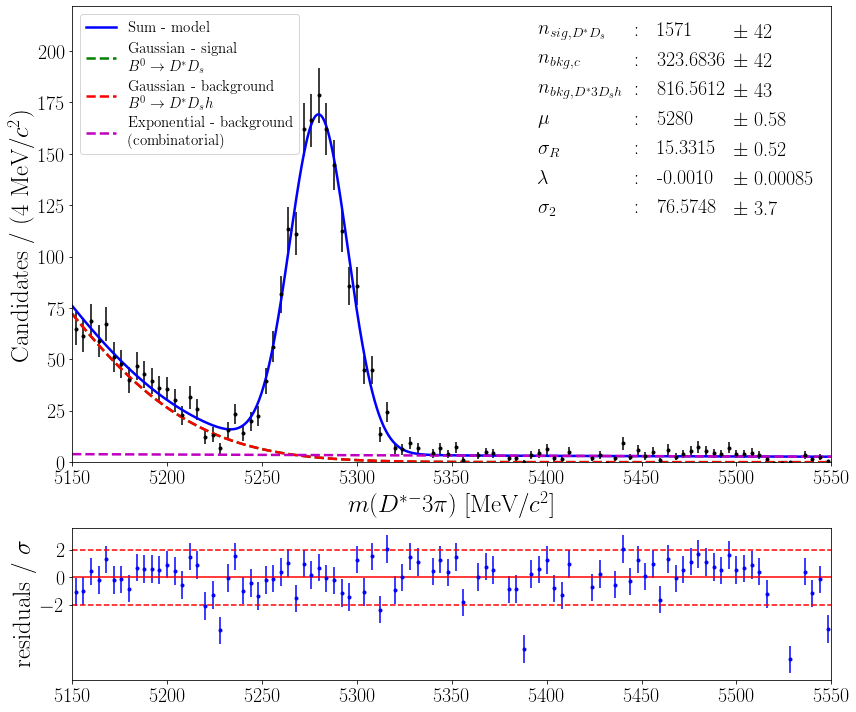

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_Ds_weighted_V8/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8_fit.pdf


/afs/cern.ch/user/c/correian/bd2dst3pi/scripts/functions.py:580: RuntimeWarning: invalid value encountered in sqrt
  err = np.sqrt(counts)


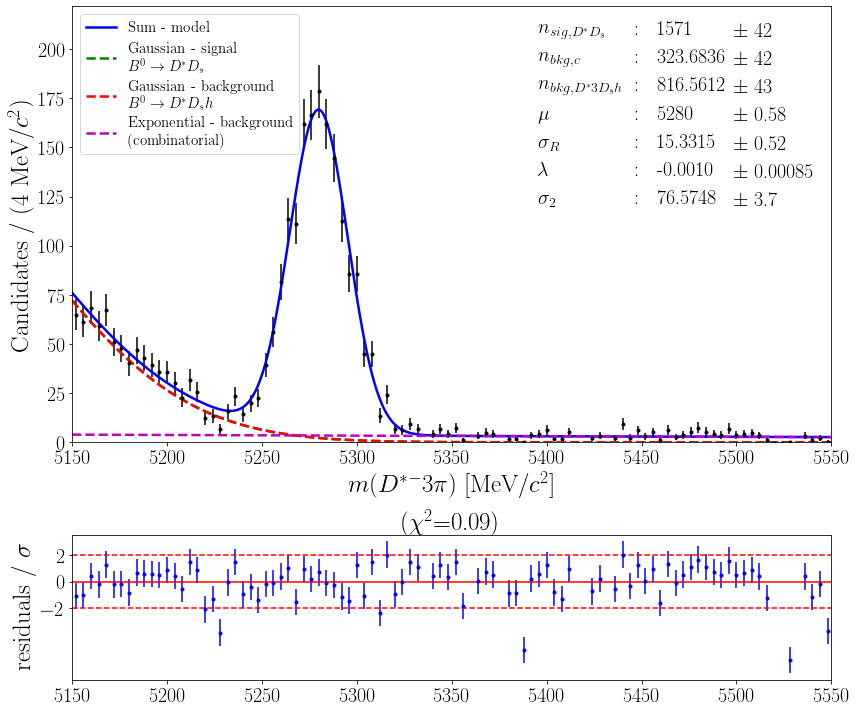

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_Ds_weighted_V8_chi2/B0_M_all_data_strip_cutDeltaM_Ds_weighted_V8_chi2_fit.pdf


In [16]:
name_data_plot = name_data
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussian_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = [None, '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot,
                       colors=['b','g','r','m','cyan','y'], weights=weights.sig,
                       params=params_B0Ds,name_params=name_params_B0Ds,
                       colWidths=[0.07,0.01,0.05,0.06],
                       fontsize_leg=15)
name_data_plot = name_data + '_chi2'
plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussian_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
                       name_models = [None, '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
                                      '\n (combinatorial)'],
                       obs=obs_B0Ds, n_bins = 100,mode_hist = False,
                       name_data = name_data_plot,
                       colors=['b','g','r','m','cyan','y'], weights=weights.sig,
                       params=params_B0Ds,name_params=name_params_B0Ds, show_chi2=True,
                       colWidths=[0.07,0.01,0.05,0.06],
                       fontsize_leg=15)

In [18]:
save_params(params_B0Ds,name_data,True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_Ds_weighted_V8_params.json
